Import Libraries

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
#import itertools
from time import time

from sklearn.cluster import KMeans
from sklearn import metrics #import silhouette_samples, silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer

import plotly.io as pio
pio.renderers
pio.renderers.default = "browser"

import Preprocess as pp
import Viz as viz

np.set_printoptions(precision = 3)

Set defaults

In [12]:
RANDOM_STATE = 42

df, column_trans, idx = pp.preprocessData()

log scaled ['total_sale_price', 'assessed_building_value', 'heated_area', 'unemploy_rate', 'pop_growth_rate', 'covid_cases', 'lumber_price', 'metals_price', 'supply', 'assessed_value_per_heated_area']
std scales ['story_height', 'mort_rate', 'build_price', 'int_rate', 'demand', 'year', 'crime']


In [13]:
X = df.drop(columns='log_scaled__total_sale_price')
y = df['log_scaled__total_sale_price']

In [ ]:
column_trans

ColumnTransformer(transformers=[('onehot', OneHotEncoder(),
                                 ['physical_zip_code', 'physical_city']),
                                ('log_scaled',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'log1p'>)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['total_sale_price', 'assessed_building_value',
                                  'heated_area', 'unemploy_rate',
                                  'pop_growth_r...vid_cases',
                                  'lumber_price', 'metals_price', 'supply',
                                  'assessed_value_per_heated_area']),
                                ('mm_scaled', MinMaxScaler(),
                                 ['bath_fixtures', 'bath']),
                                ('std_scale', StandardScaler(),
                                 ['story_height', 'mort_rate', 'build_price',
                                  'int_rate', 'demand', 'year', 'crime']),
                                ('passthru', 'passthrough',
                                 ['electric', 'gas', 'water', 'sewer', 'all',
                                  'is_covid', 'covid_year_timeline'])])

In [ ]:
idx

{'onehot': slice(0, 43, None),
 'log_scaled': slice(43, 53, None),
 'mm_scaled': slice(53, 55, None),
 'std_scale': slice(55, 62, None),
 'passthru': slice(62, 69, None),
 'remainder': slice(0, 0, None)}

# K-Means Clustering

### Elbow Method

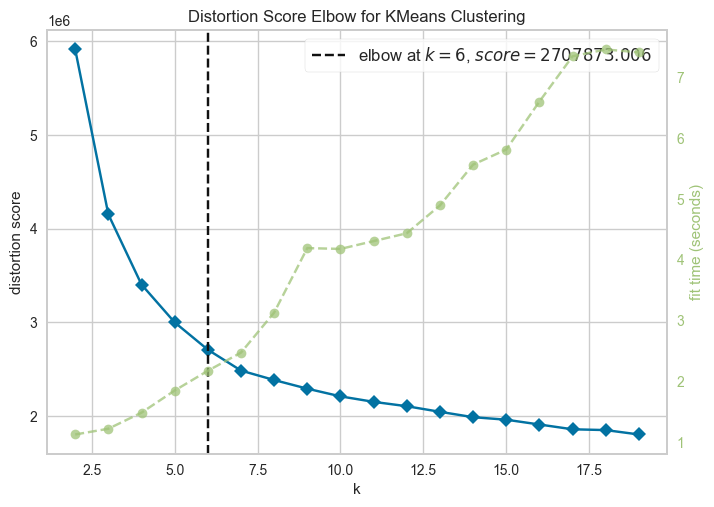

In [ ]:
# initiate kmeans instance
kmeans = KMeans(init='k-means++', random_state=RANDOM_STATE)

# show results for full dataset
elb_visualizer = KElbowVisualizer(kmeans, k=(2,20)).fit(X).show()  

### Silhouette Score

In [ ]:
print(40 * "_")
print("init\t\ttime\tinertia\tsilhouette") #"\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
for i in range(2, 21):
    name = str(i)+' clusters'
    t0 = time()
    kmeans = KMeans(init="k-means++", n_clusters=i, random_state=RANDOM_STATE)
    estimator = make_pipeline(kmeans).fit(X)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]
    results += [
        metrics.silhouette_score(
            X,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=20000,
            random_state=RANDOM_STATE
        )
    ]
    
    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}"#\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

print(40 * "_")

    

________________________________________
init		time	inertia	silhouette
2 clusters	0.985s	5912320	0.515
3 clusters	1.228s	4151277	0.357
4 clusters	1.392s	3403025	0.324
5 clusters	1.637s	2999532	0.304
6 clusters	1.965s	2707873	0.265
7 clusters	2.554s	2485083	0.267
8 clusters	3.212s	2384056	0.245
9 clusters	4.406s	2291778	0.199
10 clusters	4.173s	2209761	0.204
11 clusters	4.073s	2151136	0.195
12 clusters	4.399s	2104608	0.185
13 clusters	4.910s	2044913	0.184
14 clusters	6.046s	1987498	0.184
15 clusters	6.684s	1960646	0.181
16 clusters	7.568s	1909319	0.163
17 clusters	7.600s	1858270	0.156
18 clusters	7.820s	1849821	0.155
19 clusters	7.802s	1802965	0.153
20 clusters	8.808s	1767883	0.160
________________________________________


Visualize Silhoutte Score and Scatter plot for 2, 3, and 4 cluster because they have the highest scores.

For n_clusters = 2 The average silhouette_score is : 0.5148463245868611
For n_clusters = 3 The average silhouette_score is : 0.35653624360665137
For n_clusters = 4 The average silhouette_score is : 0.324463644125707


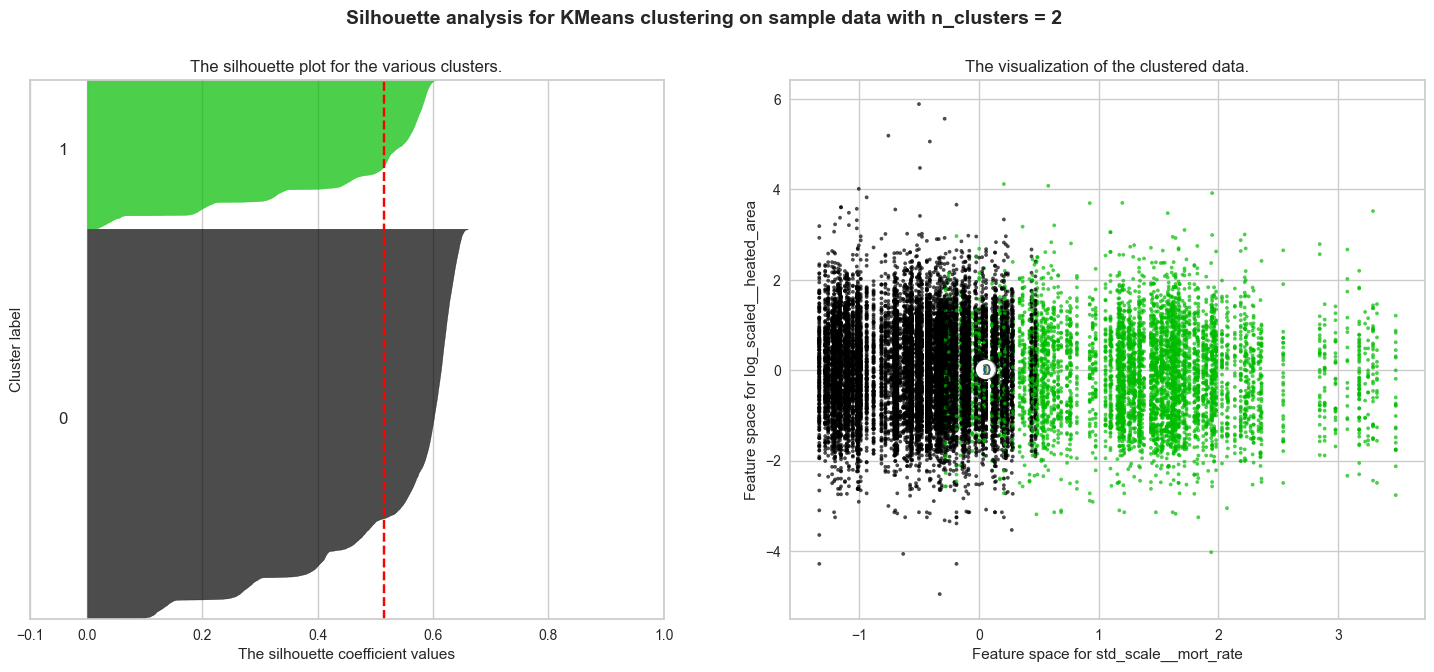

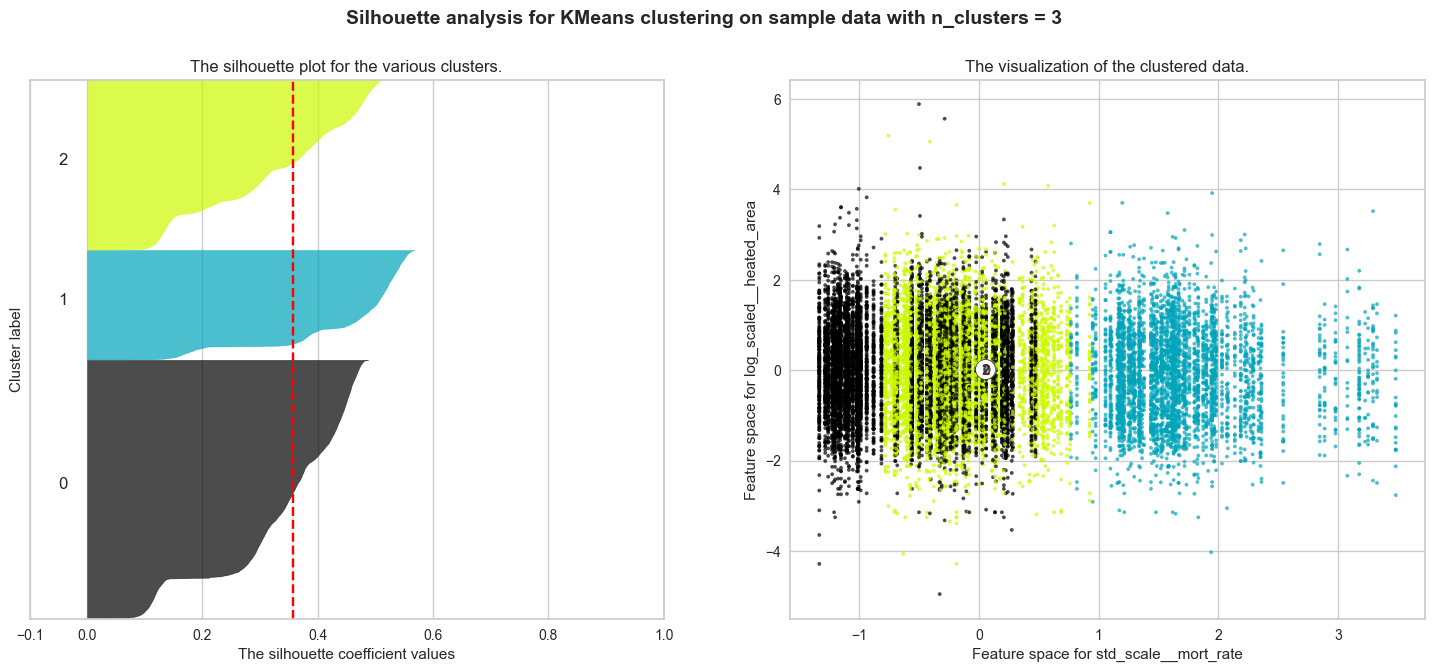

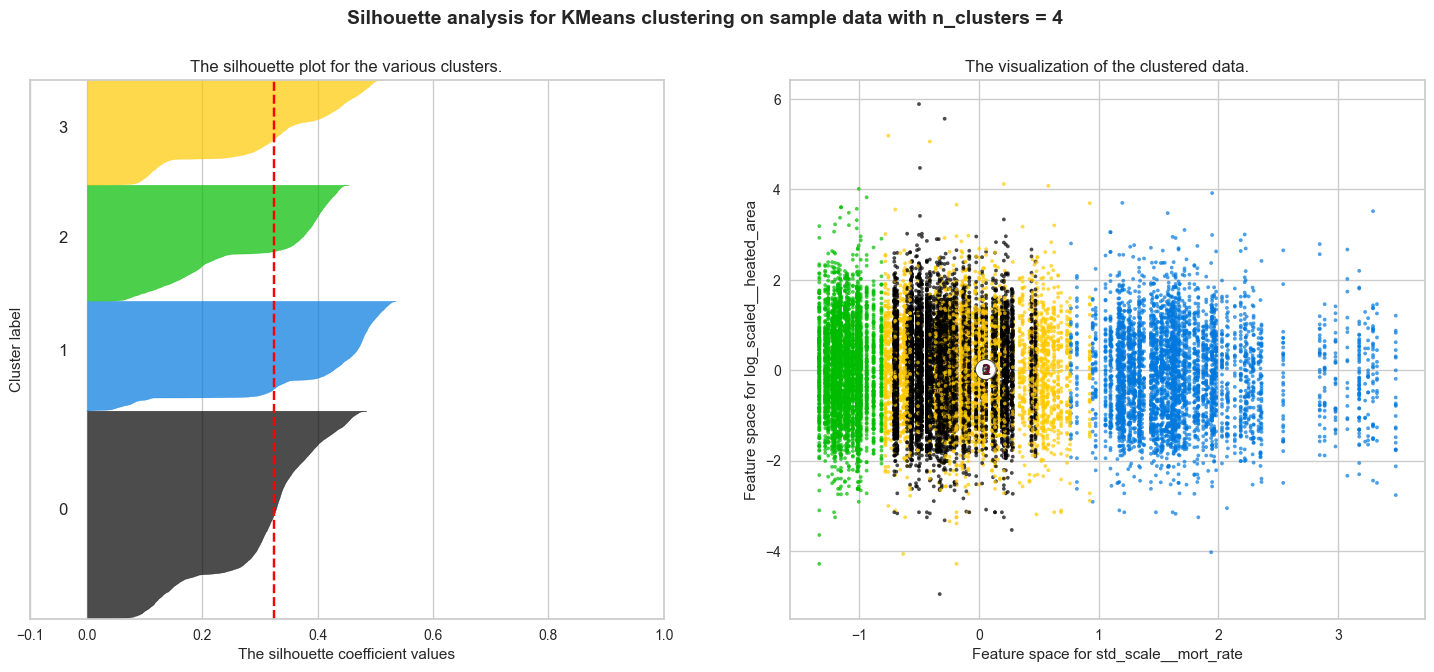

In [4]:
range_n_clusters = [2, 3, 4]
ax = 'std_scale__mort_rate'
ay = 'log_scaled__heated_area'

viz.draw_silhouette(X, k=range_n_clusters, ax=ax, ay=ay, random_state=RANDOM_STATE, sample=20000)

# Kmeans with PCA

### PCA


PCA allows to project the data from the original 69-dimensional space into a lower dimensional space. Subsequently, we can use PCA to project into a 2-dimensional space and plot the data and the clusters in this new space. - sklearn

In [5]:
pca = PCA(n_components=None, random_state=RANDOM_STATE)
pca.fit(X)
explained = pca.explained_variance_ratio_

Scree Plot

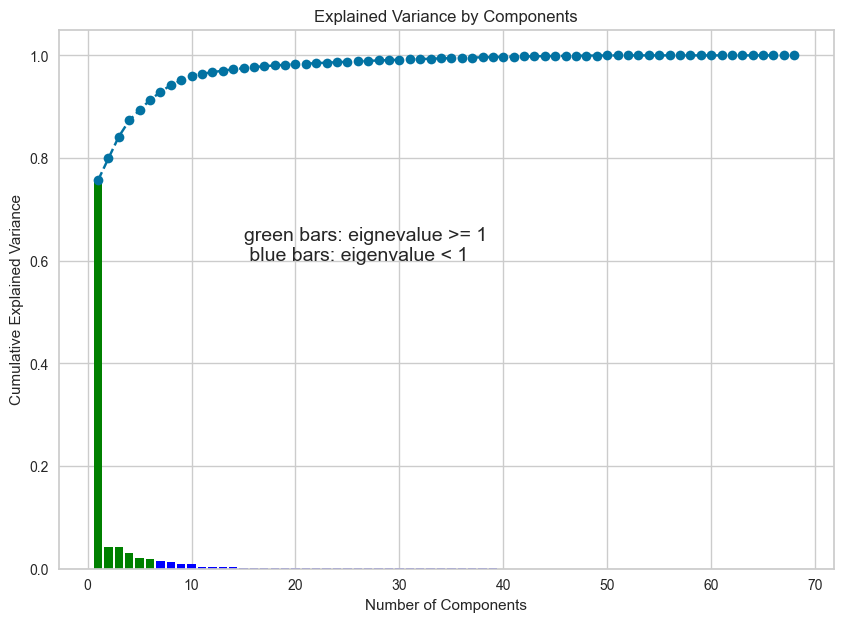

In [6]:
colors = ["green" if i >= 1 else "blue" for i in pca.explained_variance_]

plt.figure(figsize = (10,7))
plt.plot(range(1, len(explained)+1), explained.cumsum(), marker='o', linestyle = '--')
plt.bar(range(1, len(explained)+1), explained, color = colors),
plt.text(15, 0.6, 'green bars: eignevalue >= 1\n blue bars: eigenvalue < 1', fontsize = 14)
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [7]:
pca.explained_variance_

array([4.081e+01, 2.308e+00, 2.285e+00, 1.695e+00, 1.097e+00, 1.053e+00,
       8.371e-01, 7.306e-01, 4.966e-01, 4.886e-01, 1.937e-01, 1.736e-01,
       1.634e-01, 1.367e-01, 1.162e-01, 1.147e-01, 1.012e-01, 8.161e-02,
       6.723e-02, 6.034e-02, 5.720e-02, 5.484e-02, 5.169e-02, 4.983e-02,
       4.934e-02, 4.621e-02, 4.257e-02, 4.138e-02, 3.885e-02, 3.809e-02,
       3.658e-02, 3.524e-02, 3.352e-02, 3.299e-02, 3.210e-02, 2.946e-02,
       2.892e-02, 2.732e-02, 2.557e-02, 2.276e-02, 2.055e-02, 2.033e-02,
       1.880e-02, 1.764e-02, 1.459e-02, 1.400e-02, 1.247e-02, 1.128e-02,
       8.044e-03, 5.633e-03, 5.102e-03, 1.677e-03, 1.047e-03, 7.737e-04,
       1.738e-06, 7.954e-26, 8.427e-27, 5.787e-27, 4.385e-27, 3.957e-27,
       3.151e-27, 2.728e-27, 2.617e-27, 1.279e-27, 9.723e-28, 8.997e-28,
       2.648e-28, 8.048e-30])

The eigenvalues (variance explained by each PC) for PCs can help to retain the number of PCs. According to Kaiser’s rule, PCs with eigenvalues > 1 contributes greater variance and should be retained for further analysis.

We perform PCA with the chosen number of components.

In [23]:
n = 6
pca_n = PCA(n_components=6, random_state=42)
pca_n_features = pca_n.fit_transform(X)
pca_n_explained = pca_n.explained_variance_

print('Shape before PCA: ', X.shape)
print('Shape after PCA: ', pca_n_features.shape)

Shape before PCA:  (259024, 68)
Shape after PCA:  (259024, 6)


Scree Plot of n_components = 6

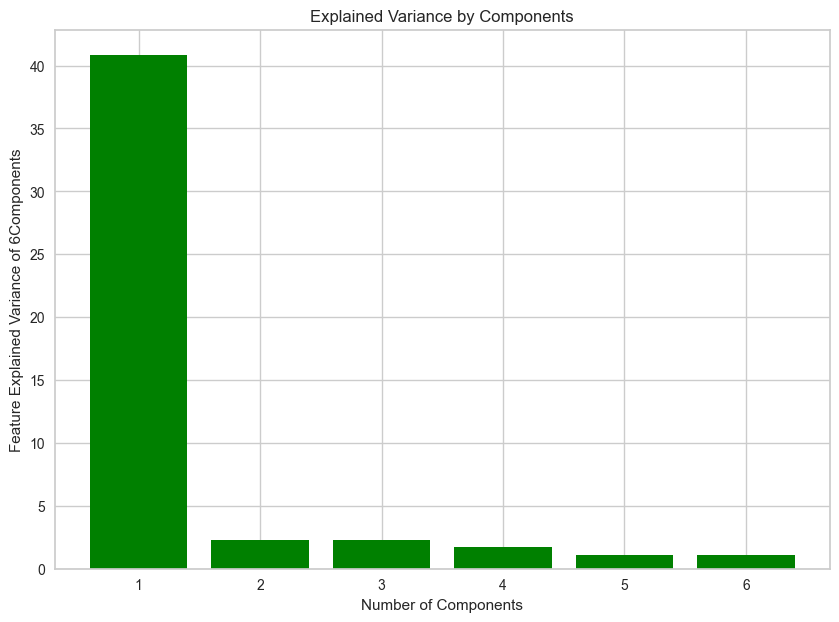

In [24]:
plt.figure(figsize = (10,7))
#plt.plot(range(1, len(pca_n_explained)+1), pca_n_explained.cumsum(), marker='o', linestyle = '--')
plt.bar(range(1, len(pca_n_explained)+1), pca_n_explained, color = colors)
#plt.text(15, 0.6, 'green bars: eignevalue >= 1\n blue bars: eigenvalue < 1', fontsize = 14)
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Feature Explained Variance of '+str(n)+'Components')
plt.show()

In [37]:
# change the pca-transformed matrix to df
colnames = ['PC'+str(i) for i in range(1,n+1)]
pca_n_df = pd.DataFrame(pca_n_features, columns=colnames)

### Try Kmeans again using PCA matrix

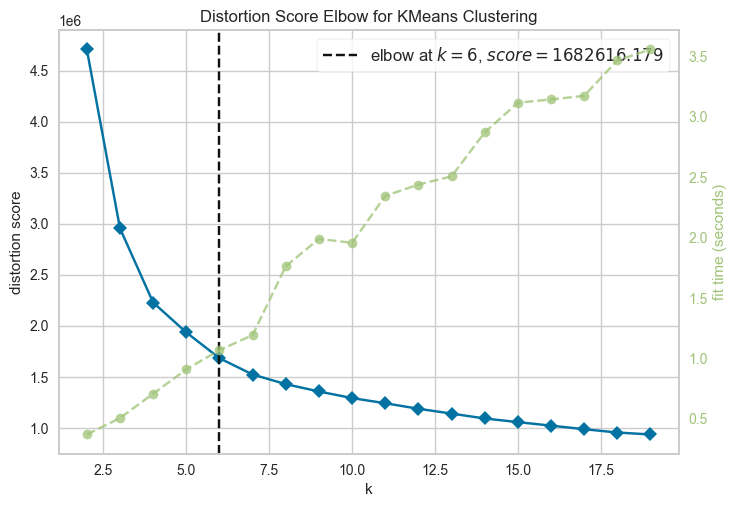

In [25]:
# initiate kmeans instance
kmeans = KMeans(init='k-means++', random_state=RANDOM_STATE)

# show results for full dataset
elb_visualizer = KElbowVisualizer(kmeans, k=(2,20)).fit(pca_n_features).show()  

In [27]:
print(40 * "_")
print("init\t\ttime\tinertia\tsilhouette") #"\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
for i in range(2, 21):
    name = str(i)+' clusters'
    t0 = time()
    kmeans = KMeans(init="k-means++", n_clusters=i, random_state=RANDOM_STATE)
    estimator = make_pipeline(kmeans).fit(pca_n_features)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]
    results += [
        metrics.silhouette_score(
            pca_n_features,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=20000,
            random_state=RANDOM_STATE
        )
    ]
    
    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}"#\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

print(40 * "_")

________________________________________
init		time	inertia	silhouette
2 clusters	0.412s	4706021	0.563
3 clusters	0.517s	2954226	0.430
4 clusters	0.737s	2227727	0.409
5 clusters	0.939s	1935365	0.363
6 clusters	1.102s	1682616	0.344
7 clusters	1.323s	1522818	0.331
8 clusters	1.942s	1428611	0.317
9 clusters	2.130s	1356743	0.296
10 clusters	2.119s	1292007	0.284
11 clusters	2.504s	1241619	0.268
12 clusters	2.613s	1187408	0.284
13 clusters	2.601s	1140297	0.261
14 clusters	3.037s	1092232	0.268
15 clusters	3.157s	1056807	0.264
16 clusters	3.229s	1022209	0.251
17 clusters	3.264s	987522	0.258
18 clusters	3.464s	954943	0.254
19 clusters	3.499s	935727	0.247
20 clusters	3.395s	904724	0.249
________________________________________


For n_clusters = 2 The average silhouette_score is : 0.5631856762435534
For n_clusters = 3 The average silhouette_score is : 0.43014086735356305
For n_clusters = 4 The average silhouette_score is : 0.40914884313840344


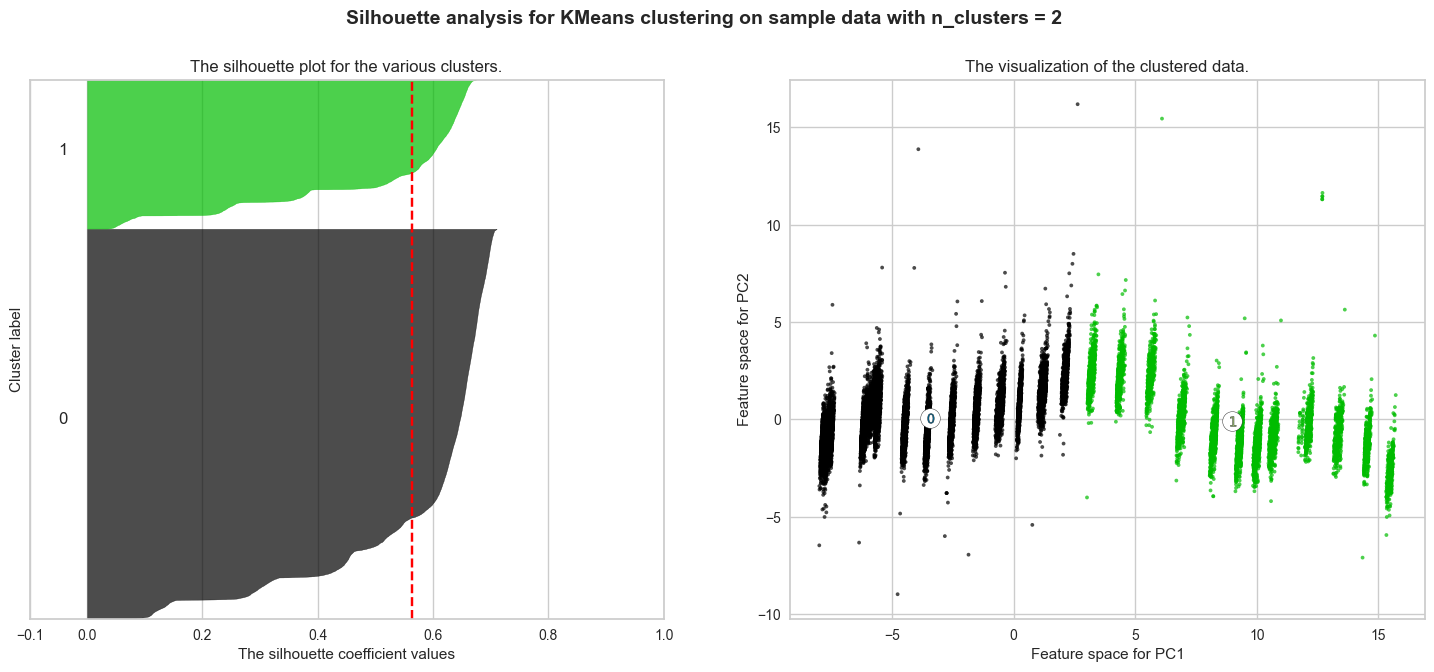

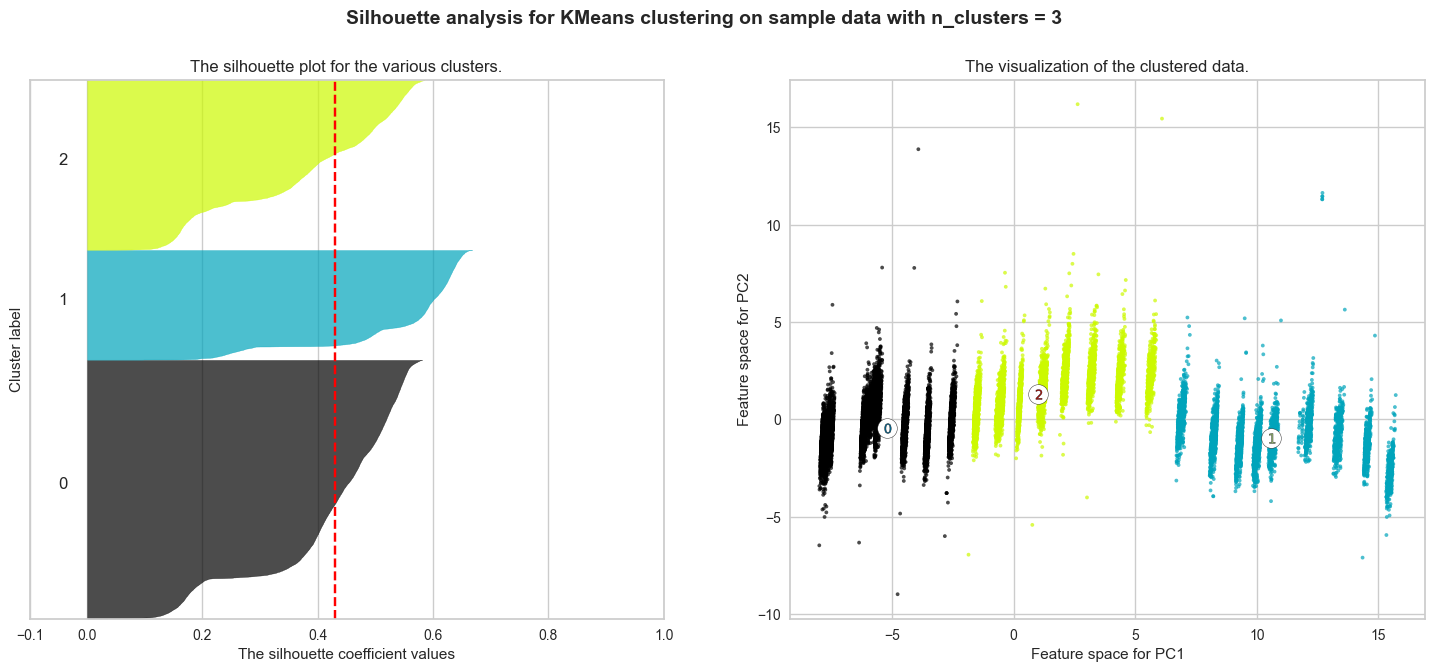

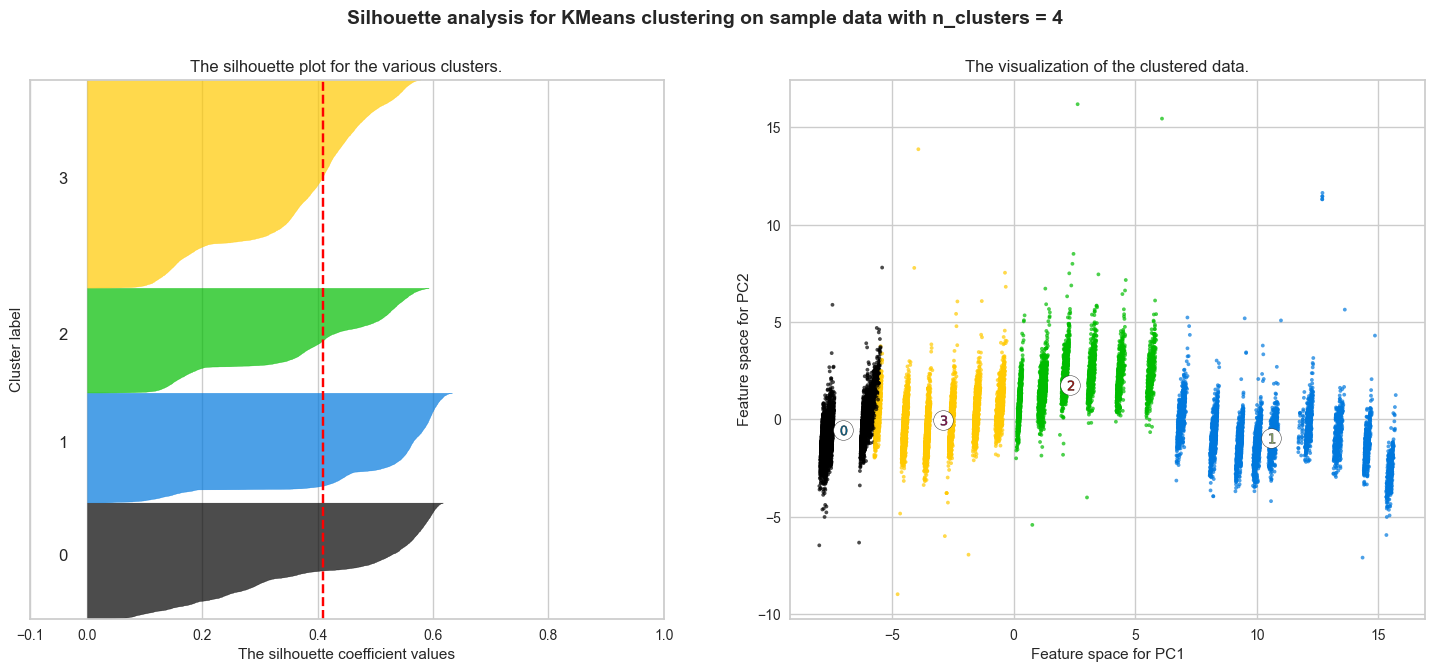

In [38]:
range_n_clusters = [2, 3, 4]
ax = 'PC1'
ay = 'PC2'

viz.draw_silhouette(pca_n_df, k=range_n_clusters, ax=ax, ay=ay, random_state=RANDOM_STATE, sample=20000)

# TODO below

### K-means clustering with PCA results

In [ ]:
# create a new DF with original features and add PCA scores and assigned clusters
df_seg_pca_kmeans = pd.concat([df_temp.reset_index(drop=True), pd.DataFrame(scores_pca)], axis =1)

df_seg_pca_kmeans['ClusterLabels'] = kmeans.labels_
df_seg_pca_kmeans.columns.values[-PC_chosen:] = PC
# name the clusters segments,
df_seg_pca_kmeans['Segments'] = df_seg_pca_kmeans['ClusterLabels'].map({0:''})

#Overlaying Clusters on Scaled Data

In [39]:
#selected_k=4

#viz.draw_cluster_scatter(X, k=selected_k, random_state=RANDOM_STATE)

